In [3]:
import os
import math
import time
import argparse
import h5py
from tqdm import tqdm
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from biggan import (BigGAN, one_hot_from_names, one_hot_from_int, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)

In [4]:
device = torch.device('cuda')
generator = BigGAN.from_pretrained('biggan-deep-512').to(device)

In [85]:
samples_data = h5py.File('gan_samples.hdf5', 'r')
samples_data_labels = h5py.File('gan_samples_labels.hdf5', 'r')
with open('./feature_direction.pkl', 'rb') as file:
    pickler = pickle.load(file)
    feature_slope, norm_vector = pickler['slopes'], pickler['norm'].reshape((-1,))

In [90]:
n = 10
print(np.argpartition(norm_vector, -n)[-n:] + 1)

[101 121   7  90  87   5  24  28  27   1]


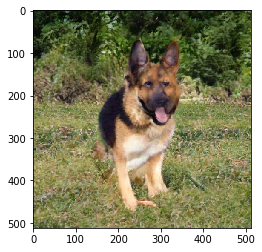

In [126]:
g_input_shape = 128
batch_size = 7
imagenet_class = 235

latents_c = truncated_noise_sample(truncation=0.7, batch_size=1)

class_vector = torch.from_numpy(one_hot_from_int(imagenet_class, batch_size=batch_size)).to(device)
output = generator(torch.from_numpy(latents_c).to(device), class_vector[0].unsqueeze(0), 0.7)
output = output.permute(0, 2, 3, 1)
output = (((output + 1) / 2.0) * 256 ).round().clamp(0, 255)
original_image = output.squeeze(0).detach().cpu().numpy().astype(np.uint8)

plt.imshow(original_image.astype(np.uint8))

In [127]:
i_feature = 7
actual_feature = i_feature-1
print('feature norm', norms[actual_feature])

latents_0 = latents_c - feature_slope[:, actual_feature][None, :]*1
latents_1 = latents_c + feature_slope[:, actual_feature][None, :]*1
latents = np.random.randn(batch_size, g_input_shape)
for i_alpha, alpha in enumerate(np.linspace(0, 1, batch_size)):
    latents[i_alpha, :] = latents_0[0]*(1-alpha) + latents_1[0]*alpha

noise_vector = torch.from_numpy(latents).float().to(device)

feature norm 0.99999994


In [128]:
images = np.zeros((noise_vector.shape[0], 512, 512, 3))
with torch.no_grad():
    for i in tqdm(range(noise_vector.shape[0])):
        noise_v = noise_vector[i].unsqueeze(0)
        output = generator(noise_v, class_vector[i].unsqueeze(0), 0.7)
        output = output.permute(0, 2, 3, 1)
        output = (((output + 1) / 2.0) * 256 ).round().clamp(0, 255)
        images[i] = output.squeeze(0).cpu().numpy().astype(np.uint8)
print(images.shape)

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

(7, 512, 512, 3)


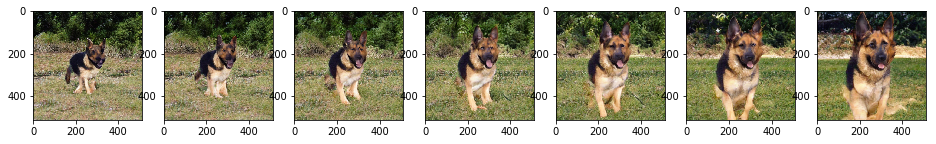

In [129]:
fig = plt.figure(figsize=(16, 5))
cols = 7
rows = 1

for i, image in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.astype(np.uint8))
plt.show()

In [130]:
import matplotlib
foldername = 'dogorange'
filename = 'dogorange'
if not os.path.exists(filename):
    os.mkdir(filename)
pickle.dump( latents_c, open( './{}/{}_latent.pkl'.format(foldername, filename), "wb" ) )
matplotlib.image.imsave('./{}/{}_original.jpg'.format(foldername, filename), 256. - original_image.astype(np.uint8))
for i, image in enumerate(images):
    matplotlib.image.imsave('./{}/{}_{}.jpg'.format(foldername, filename ,i), 256. - image)